## Automatic Differentiation

In [1]:
f(x) = 3x^2 + 2x + 1

f (generic function with 1 method)

In [2]:
f(5)

86

In [3]:
using Flux: gradient

In [4]:
df(x) = gradient(f, x)[1]
df(5)

32.0

In [5]:
ddf(x) = gradient(df, x)[1]
ddf(5)

6.0

In [6]:
mysin(x) = sum((-1)^k*x^(1+2k)/factorial(1+2k) for k in 0:5)

x = 0.5

println("$(mysin(x)) $(gradient(mysin, x)[1])")
println("$(sin(x)) $(cos(x))")

0.4794255386041834 0.8775825618898637
0.479425538604203 0.8775825618903728


In [7]:
myloss(W, b, x) = sum(W*x .+ b)

W = randn(3, 5)
b = zeros(3)
x = rand(5)

gradient(myloss, W, b, x)[1]

3×5 Matrix{Float64}:
 0.715443  0.481603  0.398456  0.165118  0.147926
 0.715443  0.481603  0.398456  0.165118  0.147926
 0.715443  0.481603  0.398456  0.165118  0.147926

In [8]:
gradient(myloss, W, b, x)[2]

3-element Fill{Float64}, with entries equal to 1.0

In [9]:
gradient(myloss, W, b, x)[3]

5-element Vector{Float64}:
 -0.9868991036685171
 -0.6910209229708004
 -1.2169461361271297
 -1.0332464230016447
  0.6556616243481761

In [10]:
using Flux: params

W = randn(3, 5)
b = zeros(3)
x = rand(5)

y(x) = sum(W*x .+ b)

grads = gradient(() -> y(x), params([W, b]))

grads[W]

3×5 Matrix{Float64}:
 0.906441  0.269754  0.341238  0.0543369  0.554015
 0.906441  0.269754  0.341238  0.0543369  0.554015
 0.906441  0.269754  0.341238  0.0543369  0.554015

In [11]:
grads[b]

3-element Fill{Float64}, with entries equal to 1.0

In [12]:
using Flux

In [13]:
m = Dense(10, 5)

x = rand(Float32, 10)

10-element Vector{Float32}:
 0.49049127
 0.899681
 0.28253758
 0.04710388
 0.55048835
 0.09113455
 0.7153944
 0.20714808
 0.17542267
 0.46283495

In [14]:
params(m)

Params([Float32[0.26748532 0.041452087 … -0.5659295 -0.52498823; 0.24926351 0.005207503 … 0.48203883 0.14712693; … ; -0.10200404 0.2301632 … 0.12095009 -0.121845774; 0.49329856 -0.3020207 … 0.5886186 0.1275637], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

In [15]:
x = rand(Float32, 10)
m = Chain(
    Dense(10, 5, relu),
    Dense(5, 2),
    softmax
)

l(x) = sum(Flux.crossentropy(m(x), [0.5, 0.5]))

grads = gradient(params(m)) do
    l(x)
end

for p in params(m)
    println(grads[p])
end

Float32[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.09091924 0.097100474 0.096241154 0.10143307 0.23038448 0.23134968 0.070432134 0.19477189 0.095890686 0.14892006; -0.061405446 -0.06558015 -0.06499978 -0.06850632 -0.1555981 -0.15624999 -0.047568772 -0.1315459 -0.064763084 -0.1005783; 0.020446124 0.021836173 0.021642929 0.022810496 0.05180938 0.05202644 0.015838938 0.04380074 0.021564113 0.03348948; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0]
Float32[0.0, 0.2400574, -0.16213104, 0.05398465, -0.0]
Float32[0.0 0.2957765 0.10825028 0.16150431 0.0; -0.0 -0.2957765 -0.10825028 -0.16150431 -0.0]
Float32[0.24237242, -0.24237242]


In [16]:
for p in params(m)
    println(size(p))
end

(5, 10)
(5,)
(2, 5)
(2,)


In [17]:
using Flux.Optimise: update!, Descent
η = 0.1
for p in params(m)
    update!(p, -η * grads[p])
end

In [18]:
opt = Descent(0.01)

epochs = 200
train_loss = Vector{Float32}(undef, epochs) 
data, labels = rand(10, 100), fill(0.5, 2, 100)
loss(x, y) = sum(Flux.crossentropy(m(x), y))
for i in 1:epochs
    Flux.train!(loss, params(m), [(data, labels)], opt)
    train_loss[i] = loss(data, labels)
end

In [19]:
m(data)

2×100 Matrix{Float64}:
 0.450769  0.622518  0.513046  0.394082  …  0.508132  0.452728  0.566739
 0.549231  0.377482  0.486954  0.605918     0.491868  0.547272  0.433261

In [20]:
labels

2×100 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5  0.5  0.5

In [21]:
using Plots

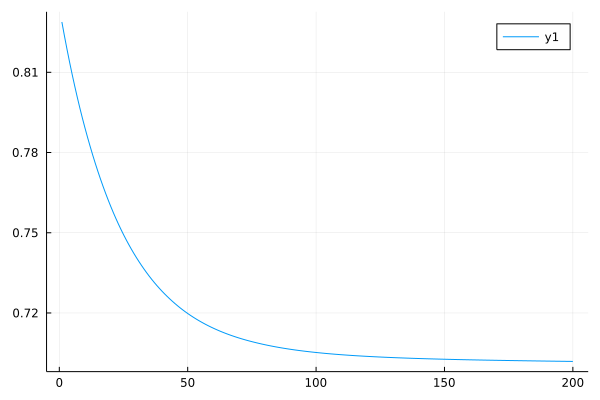

In [22]:
plot(1:epochs, train_loss)

## CIFAR10

In [23]:
using Statistics
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition
using CUDA

In [24]:
Metalhead.download(CIFAR10)

In [25]:
X = trainimgs(CIFAR10);

In [26]:
X[1].ground_truth.class

7

In [27]:
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000], 1:10)

10×50000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

,,,,,,,,,

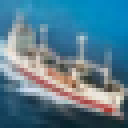
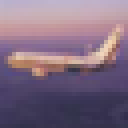
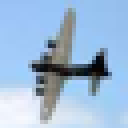
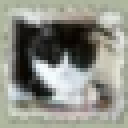
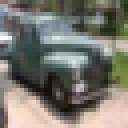
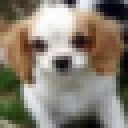
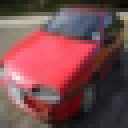
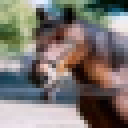
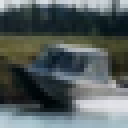
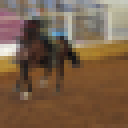

In [28]:
using StatsBase

image(x) = x.img
ground_truth(x) = x.ground_truth
image.(X[sample(1:end, 10)])

In [29]:
getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000];

In [30]:
train = ([(cat(imgs[i]..., dims=4), labels[:,i]) for i in partition(1:49000, 1000)]) |> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims=4) |> gpu
valY = labels[:, valset] |> gpu

10×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

In [31]:
m = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax
) |> gpu

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#13#14"(),
  Dense(200, 120),                      # 24_120 parameters
  Dense(120, 84),                       # 10_164 parameters
  Dense(84, 10),                        # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.852 KiB.

In [32]:
using Flux: Momentum

loss(x, y) = sum(Flux.crossentropy(m(x), y))
opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any, Any}())

In [33]:
accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

accuracy (generic function with 1 method)

In [34]:
epochs = 200

max_val_acc = 0
max_stack = 0

for epoch = 1:epochs
    for d in train
        gs = gradient(params(m)) do
            l = loss(d...)
        end
        update!(opt, params(m), gs)
    end
#     train!(loss, params(m), train, opt)
    val_acc = accuracy(valX, valY)
    
    @show val_acc, opt.eta
    
    if val_acc >= max_val_acc
        max_val_acc = val_acc
        max_stack = 0
    else
        max_stack += 1
    end
    
    if max_stack >= 5
        opt.eta /= 10
    end
    
    if opt.eta <= 1e-7
        break
    end
end

(val_acc, opt.eta) = (0.222, 0.01)
(val_acc, opt.eta) = (0.332, 0.01)
(val_acc, opt.eta) = (0.351, 0.01)
(val_acc, opt.eta) = (0.366, 0.01)
(val_acc, opt.eta) = (0.406, 0.01)
(val_acc, opt.eta) = (0.426, 0.01)
(val_acc, opt.eta) = (0.441, 0.01)
(val_acc, opt.eta) = (0.467, 0.01)
(val_acc, opt.eta) = (0.477, 0.01)
(val_acc, opt.eta) = (0.487, 0.01)
(val_acc, opt.eta) = (0.505, 0.01)
(val_acc, opt.eta) = (0.513, 0.01)
(val_acc, opt.eta) = (0.526, 0.01)
(val_acc, opt.eta) = (0.534, 0.01)
(val_acc, opt.eta) = (0.548, 0.01)
(val_acc, opt.eta) = (0.554, 0.01)
(val_acc, opt.eta) = (0.557, 0.01)
(val_acc, opt.eta) = (0.557, 0.01)
(val_acc, opt.eta) = (0.561, 0.01)
(val_acc, opt.eta) = (0.56, 0.01)
(val_acc, opt.eta) = (0.568, 0.01)
(val_acc, opt.eta) = (0.559, 0.01)
(val_acc, opt.eta) = (0.572, 0.01)
(val_acc, opt.eta) = (0.565, 0.01)
(val_acc, opt.eta) = (0.572, 0.01)
(val_acc, opt.eta) = (0.577, 0.01)
(val_acc, opt.eta) = (0.579, 0.01)
(val_acc, opt.eta) = (0.584, 0.01)
(val_acc, opt.eta) = 

In [35]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)]);

,,,,,,,,,

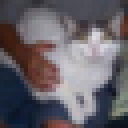
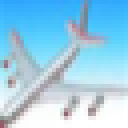
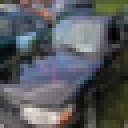
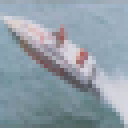
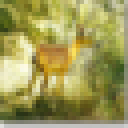
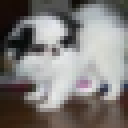
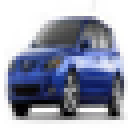
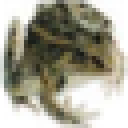
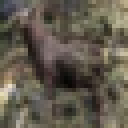
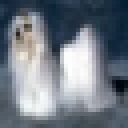

In [36]:
ids = rand(1:10000, 10)
image.(valset[ids])

In [37]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)

10×10 Matrix{Float32}:
 0.0164257   0.676025     0.0713295  0.265615     …  0.00412695   0.000239813
 0.0111559   0.000186292  0.245573   0.000121262     0.00257517   2.05385f-6
 0.0191939   0.275809     0.204069   0.104775        0.156801     0.0152521
 0.480147    0.00199076   0.119577   0.0235242       0.0467995    0.217764
 0.0284082   0.0032183    0.0137051  0.0397742       0.38355      0.00337794
 0.174326    0.000712441  0.129289   0.0212359    …  0.0535645    0.709948
 0.157413    5.75091f-6   0.0286009  0.00427804      0.107055     8.04775f-6
 0.00679849  0.000908228  0.0825049  0.00297453      0.241827     0.0531251
 0.0961231   0.0397651    0.0106491  0.537414        0.000168723  0.00025355
 0.0100089   0.00137955   0.0947029  0.00028836      0.00353135   2.95465f-5

In [38]:
accuracy(test[1]...)

0.604

In [39]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

10-element Vector{Float64}:
 0.626
 0.742
 0.458
 0.404
 0.574
 0.494
 0.739
 0.673
 0.735
 0.683

In [40]:
using BSON: @save

In [41]:
@save "mymodel.bson" m